# Processing, curation, and filtering of data collected by Luis from Bergey's manual volumen 5 (Actinobacteria).

### Preparation

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean
from Bio import Entrez
import time
import re
from bs4 import BeautifulSoup
import requests

In [2]:
# Interactive matplotlib plot
%matplotlib notebook

### Data tables

In [3]:
df = pd.read_excel('BMvol5.csv')
df.shape

(918, 7)

### Processing

Drop entries without `shape`

In [4]:
df = df.dropna(subset = ['shape'])
df.shape

(760, 7)

Drop entries without `length` and `width`

In [5]:
df = df.dropna(subset = ['length mum', 'width mum'], how = 'all')
df.shape

(467, 7)

### Composed-shape, e.g. rods-coccus

In [6]:
df['shape'].value_counts()

rods                342
coccus               67
sphere               18
rods-coccus          15
coccus-bacilli        8
hyphae                3
mycelium              3
cylindrical           2
rods                  2
filaments             2
coryneforms           1
diphteroid            1
oval                  1
bacilli               1
pleomorphic-rods      1
Name: shape, dtype: int64

If shape is `rods-coccus` and there is a single value for cell dimension (`length` or `width`), add the remaining value (because the other shape is coccus ~ sphere)

In [7]:
tmp = df[df['shape'] == 'rods-coccus'][['length mum', 'width mum']]

In [8]:
tmp[tmp.isna().any(axis=1)]

,length mum,width mum


If shape is `coccus-bacilli` and there is a single value for cell dimension (`length` or `width`), add the remaining value (because the other shape is coccus ~ sphere)

In [9]:
tmp = df[df['shape'] == 'coccus-bacilli'][['length mum', 'width mum']]

In [10]:
tmp[tmp.isna().any(axis=1)]

,length mum,width mum
278,1.2-1.4,NaN


In [11]:
df.at[278, 'width mum'] = '1.2-1.4'

Check `pleomorphic-rods`

In [12]:
df[df['shape'] == 'pleomorphic-rods']

,rank,name,shape,length mum,width mum,diameter,Unnamed: 6
782,species,cryobacterium psychrophilum,pleomorphic-rods,1.0-1.8,0.5-0.7,NaN,NaN


### More curation, processing, and filtering

Correct some error: `rods ` for `rods`

In [13]:
df[df['shape'] == 'rods ']

,rank,name,shape,length mum,width mum,diameter,Unnamed: 6
262,species,mycobacterium vanbaallenii,rods,1.4,0.7,NaN,NaN
322,species,mycobacterium hodleri,rods,1.8-2.3,1,NaN,NaN


In [14]:
df.at[262, 'shape'] = 'rods'
df.at[322, 'shape'] = 'rods'

Drop entries with only one value for cell dimension (`length` or `width`) as this is not helpful to calculate the volume or surface. **We collected the data such that if shape is `sphere`, `coccus`, `oval`, length and width values are not empty**. 

In [15]:
df = df.dropna(subset = ['length mum', 'width mum'], how = 'any').copy()

In [16]:
df.shape

(426, 7)

In [17]:
df['shape'].value_counts()

rods                310
coccus               67
sphere               18
rods-coccus          15
coccus-bacilli        8
cylindrical           2
hyphae                2
diphteroid            1
oval                  1
bacilli               1
pleomorphic-rods      1
Name: shape, dtype: int64

Drop records with `rank` != `species`

In [18]:
df['rank'].value_counts()

species     371
species      53
genus         2
Name: rank, dtype: int64

In [19]:
df = df[df['rank'].str.contains('species')].copy()
df.shape

(424, 7)

## Standardize length and width values:

- For ranges (e.g., 4-8), take geometric mean
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

First make some corrections

In [20]:
df.at[476, 'length mum'] = '5.0-20.0'

In [21]:
def size_to_num(size):
    """
    Function that converts a size string into a float number.
    Inputs:
        size: str contining the size
    Outputs:
        s: float containing the standardized size
    """
    #print(size)
    if '-' in size:
        if len(size.split('-')) == 2:
            return np.sqrt(np.prod([float(x) for x in size.split('-')]))
        elif len(size.split('-')) > 2:
            return gmean([float(x) for x in size.split('-')])
    elif size.startswith(('>', '<')):
        return float(size[1:])
    else:
        return float(size)

In [22]:
df['length'] = df['length mum'].astype(str).apply(size_to_num)

In [23]:
df['width'] = df['width mum'].astype(str).apply(size_to_num)

Make sure that length is greater than width

In [24]:
df[['length', 'width']] = df[['length', 'width']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis = 1)

## Check if organisms are already present in Bacdive

In [25]:
dataset = pd.read_table('annot/species.tsv', index_col = 0)
dataset.shape

(4875, 12)

Reformat name

In [26]:
df['name'] = df['name'].map(lambda x: x.split()[0].capitalize() + ' ' + x.split()[1])
df.shape

(424, 9)

Check if present in dataset (so far...)

In [27]:
df['name'].astype(str).isin(dataset['species']).value_counts()

False    290
True     134
Name: name, dtype: int64

In [28]:
df['in_dataset'] = df['name'].astype(str).isin(dataset['species'])

**Drop entries already present in dataset (so far...)**

In [29]:
df = df[df['in_dataset'] == False].copy()
df.shape

(290, 10)

Drop useless columns

In [30]:
df.drop(['rank', 'length mum', 'width mum', 'diameter', 'Unnamed: 6', 'in_dataset'], axis = 1, inplace = True)

In [31]:
df.shape

(290, 4)

## Data distribution

<IPython.core.display.Javascript object>


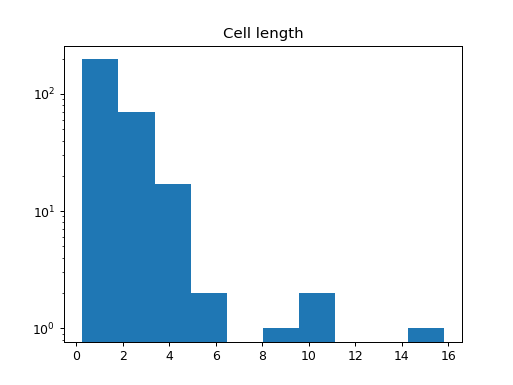

In [32]:
plt.figure()
plt.hist(df['length'], log = True)
plt.title('Cell length')
plt.show()

<IPython.core.display.Javascript object>


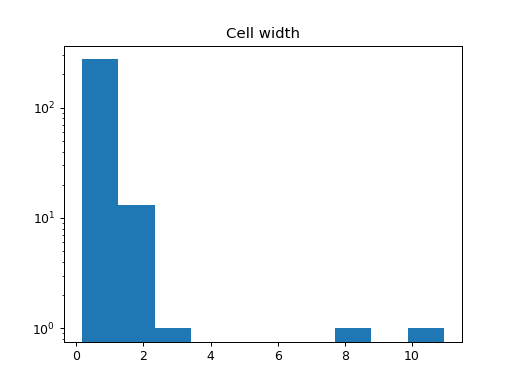

In [33]:
plt.figure()
plt.hist(df['width'], log = True)
plt.title('Cell width')
plt.show()

## Cell volume and surface area

Second, assume that cells are [capsules](https://en.wikipedia.org/wiki/Capsule_(geometry)).

- Volume: $ V = \pi r^{2} (\frac{4}{3} r + a)$

- Surface area: $ S = 2 \pi r (2r + a) $

In which $a$ = length - width, $r$ = width / 2.

In [34]:
df['volume'] = np.pi * (df['width'] / 2) ** 2 * ((4 / 3) * (df['width'] / 2) + (df['length'] - df['width']))

In [35]:
df['surface'] = 2 * np.pi * (df['width'] / 2) * (2 * (df['width'] / 2) + (df['length'] - df['width']))

In [36]:
# Set a new index
df.set_index(np.arange(0, df.shape[0]), inplace = True)

<IPython.core.display.Javascript object>


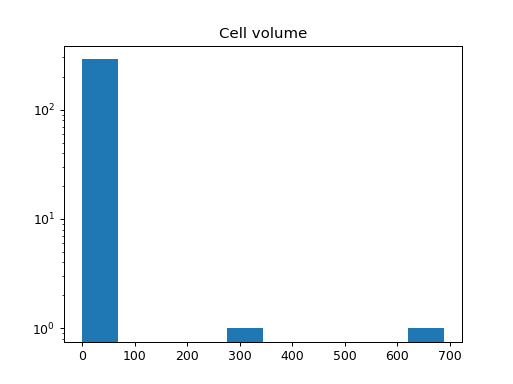

In [37]:
plt.figure()
plt.hist(df['volume'], log = True)
plt.title('Cell volume')
plt.show()

<IPython.core.display.Javascript object>


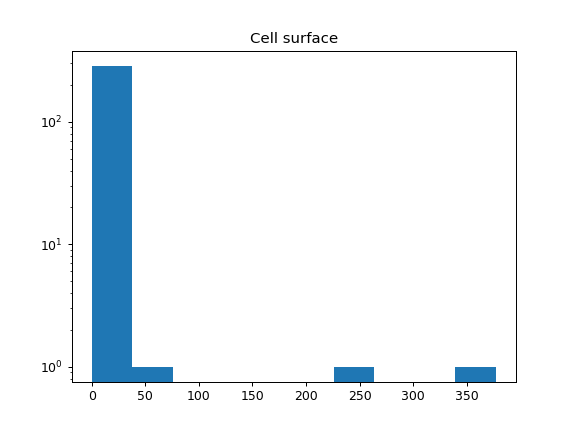

In [38]:
plt.figure()
plt.hist(df['surface'], log = True)
plt.title('Cell surface')
plt.show()

<IPython.core.display.Javascript object>


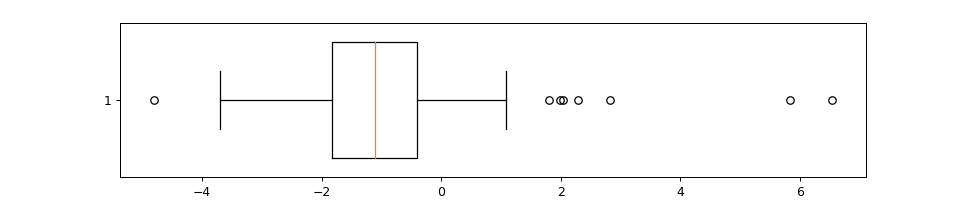

In [39]:
plt.figure(figsize = (12, 2.5))
plt.boxplot(df['volume'].apply(np.log), widths = 0.75, vert = False)
plt.show()

<IPython.core.display.Javascript object>


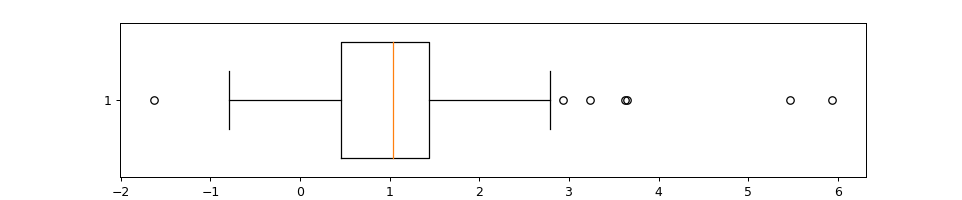

In [40]:
plt.figure(figsize = (12, 2.5))
plt.boxplot(df['surface'].apply(np.log), widths = 0.75, vert = False)
plt.show()

## Output

In [41]:
df.shape

(290, 6)

In [42]:
df.to_csv('data_BMvol5.tsv', sep = '\t')